In [33]:
import datetime
import pandas as pd
import pytz
import requests
from io import StringIO

In [74]:
sensor_id = 'pCPex6DkSdS0f5K2f7jyHg'

start_date = datetime.datetime(2023, 10, 9, 21, 0, 0)
end_date = datetime.datetime(2023, 10, 16, 21, 0, 0)

start_year = start_date.year
start_month = start_date.month
start_day = start_date.day
start_hour = start_date.hour
start_minute = start_date.minute
start_second = start_date.second
end_year = end_date.year
end_month = end_date.month
end_day = end_date.day
end_hour = end_date.hour
end_minute = end_date.minute
end_second = end_date.second

url_template = "https://www.sjvair.com/api/1.0/monitors/{}/entries/csv/?timestamp__gte={}-{}-{}+{}%3A{}%3A{}&timestamp__lte={}-{}-{}+{}%3A{}%3A{}"
url = url_template.format(sensor_id, start_year, start_month, start_day, start_hour, start_minute, start_second, end_year, end_month, end_day, end_hour, end_minute, end_second)

r = requests.get(url)

In [75]:
df = pd.read_csv(StringIO(r.text), ',')
df

,timestamp,sensor,celsius,fahrenheit,humidity,pressure,pm10,pm25,pm100,pm25_reported,pm25_avg_15,pm25_avg_60,particles_03um,particles_05um,particles_100um,particles_10um,particles_25um,particles_50um
0,2023-10-23 20:58:29.791747+00:00,b,23.9,75.0,48.0,1001.02,5.96,6.39,8.79,8.35,7.05,6.55,1115.0,329.0,0.0,62.0,2.0,0.0
1,2023-10-23 20:58:29.631286+00:00,a,23.9,75.0,48.0,1001.02,7.44,7.95,11.05,10.93,8.38,7.87,1383.0,395.0,0.0,74.0,3.0,0.0
2,2023-10-23 20:56:29.452512+00:00,b,23.3,74.0,48.0,1001.11,5.98,6.76,9.94,8.96,7.10,6.48,1115.0,328.0,0.0,68.0,4.0,1.0
3,2023-10-23 20:56:29.333981+00:00,a,23.3,74.0,48.0,1001.11,8.62,8.60,14.21,12.00,8.41,7.78,1577.0,455.0,0.0,88.0,7.0,1.0
4,2023-10-23 20:54:29.556762+00:00,b,23.3,74.0,48.0,1001.08,6.69,7.69,10.65,10.49,7.19,6.45,1243.0,364.0,0.0,77.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,2023-10-16 21:04:35.265537+00:00,a,27.2,81.0,30.0,1008.62,1.42,5.54,2.20,2.20,5.13,5.38,394.0,114.0,0.0,16.0,1.0,0.0
10070,2023-10-16 21:02:34.418789+00:00,b,27.2,81.0,30.0,1008.66,0.70,5.18,1.27,1.12,4.72,5.05,260.0,77.0,0.0,10.0,0.0,0.0
10071,2023-10-16 21:02:34.151225+00:00,a,27.2,81.0,30.0,1008.66,1.21,5.51,2.56,2.10,5.12,5.37,379.0,110.0,0.0,19.0,1.0,0.0
10072,2023-10-16 21:00:40.422990+00:00,b,27.2,81.0,30.0,1008.66,0.69,5.19,1.54,1.15,4.74,5.05,308.0,88.0,0.0,8.0,0.0,0.0


In [76]:
df.to_csv('./data/SJVAir_PurpleAir_ucm-8c88_pCPex6DkSdS0f5K2f7jyHg_export.csv', index=False)

# Timestamp Cleaning

In [80]:
sj2pa = {"9tYuybX_ROqhTm5m6je79Q": "155565",
         "CCA4NsviS-K4reZPsMUTYQ": "163173"}
pa2sj = {v: k for k, v in sj2pa.items()}
sensor_id_list = ['155565', '163173']

In [105]:
def clean_timestamp(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.tz_convert("US/Pacific")
    ts = pd.to_datetime(df["timestamp"])
    df["year"] = ts.dt.year
    df["month"] = ts.dt.month
    df["day"] = ts.dt.day
    df["hour"] = ts.dt.hour
    df["minute"] = ts.dt.minute

    df = df.drop(columns=["timestamp"])
    return df

In [107]:
def average_30min(df):
    df["minute"] = df["minute"].apply(lambda x: 0 if x < 30 else 30)
    df = df.groupby(["year", "month", "day", "hour", "minute"]).mean().reset_index()
    return df

In [111]:
for sensor_id in sensor_id_list:
    sensor_id_sj = pa2sj[sensor_id]
    df = pd.read_csv('./data/SJVAir_PurpleAir_ucm-8c88_pCPex6DkSdS0f5K2f7jyHg_export.csv'.format(sensor_id_sj), )
    df_processed = clean_timestamp(df)
    df_processed = average_30min(df_processed)
    df_processed.to_csv('./data/sj_10162023_10232023_{}(30MinMean).csv'.format(sensor_id_sj), index=False)

In [127]:
df_processed

,year,month,day,hour,minute,celsius,fahrenheit,humidity,pressure,pm10,...,pm100,pm25_reported,pm25_avg_15,pm25_avg_60,particles_03um,particles_05um,particles_100um,particles_10um,particles_25um,particles_50um
0,2023,10,16,14,0,27.200000,81.000000,30.733333,1008.590000,0.936333,...,1.652000,1.512000,4.857667,5.237333,331.166667,94.066667,0.000000,13.166667,0.566667,0.000000
1,2023,10,16,14,30,27.200000,81.000000,30.000000,1008.395333,0.827000,...,1.498667,1.371667,4.793333,5.208667,334.800000,94.500000,0.000000,12.233333,0.533333,0.000000
2,2023,10,16,15,0,27.166667,80.933333,30.200000,1008.370667,0.732333,...,1.279667,1.185000,4.714000,5.130667,301.200000,85.233333,0.000000,10.466667,0.300000,0.000000
3,2023,10,16,15,30,27.133333,80.866667,31.733333,1008.294667,0.500333,...,1.136333,0.944000,4.592333,5.047000,276.733333,78.900000,0.000000,9.533333,0.466667,0.000000
4,2023,10,16,16,0,27.200000,81.000000,32.866667,1008.104000,0.896000,...,1.672667,1.466000,4.794667,5.053667,331.933333,94.066667,0.000000,12.500000,0.633333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2023,10,23,11,30,20.600000,69.000000,55.933333,1002.082000,4.328667,...,7.901333,7.270333,5.873000,5.981333,862.800000,254.300000,0.000000,61.533333,3.666667,0.433333
332,2023,10,23,12,0,21.020000,69.800000,54.733333,1001.942667,4.066000,...,6.943000,6.576333,5.685000,5.685667,823.766667,242.166667,0.000000,56.100000,2.266667,0.166667
333,2023,10,23,12,30,22.006667,71.600000,51.400000,1001.627333,4.032667,...,6.784000,6.421000,5.254333,5.414000,813.833333,239.166667,0.000000,50.700000,2.333333,0.166667
334,2023,10,23,13,0,23.026667,73.466667,48.733333,1001.412667,5.782000,...,9.569333,8.964667,6.758000,5.682667,1100.933333,323.333333,0.066667,69.833333,3.266667,0.233333


# Visualization

In [109]:
import matplotlib.pyplot as plt
import numpy as np

In [110]:
sj2pa = {"9tYuybX_ROqhTm5m6je79Q": "155565",
         "CCA4NsviS-K4reZPsMUTYQ": "163173"}
pa2sj = {v: k for k, v in sj2pa.items()}
sensor_id_list = ['155565', '163173']

In [125]:
sensor_id1 = sensor_id_list[0]
sensor_id1_sj = pa2sj[sensor_id1]
sensor_id2 = sensor_id_list[1]
sensor_id2_sj = pa2sj[sensor_id2]
df1 = pd.read_csv("./data/sj_10162023_10232023_{}(30MinMean).csv".format(sensor_id1_sj))
df2 = pd.read_csv("./data/sj_10162023_10232023_{}(30MinMean).csv".format(sensor_id2_sj))
df1.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'celsius', 'fahrenheit',
       'humidity', 'pressure', 'pm10', 'pm25', 'pm100', 'pm25_reported',
       'pm25_avg_15', 'pm25_avg_60', 'particles_03um', 'particles_05um',
       'particles_100um', 'particles_10um', 'particles_25um',
       'particles_50um'],
      dtype='object')

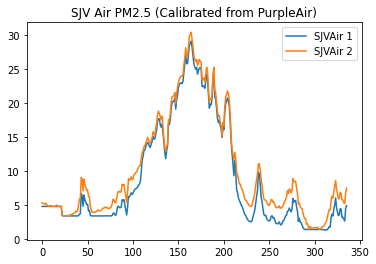

In [126]:
fig, ax = plt.subplots()
ax.plot(df1["pm25"], label="SJVAir 1")
ax.plot(df2["pm25"], label="SJVAir 2")
plt.legend()
plt.title("SJV Air PM2.5 (Calibrated from PurpleAir)")
plt.show()

In [122]:
np.mean(df1["pm25"] - df2["pm25"])

0.0

In [123]:
df1

,year,month,day,hour,minute,celsius,fahrenheit,humidity,pressure,pm10,...,pm100,pm25_reported,pm25_avg_15,pm25_avg_60,particles_03um,particles_05um,particles_100um,particles_10um,particles_25um,particles_50um
0,2023,10,16,14,0,28.300000,83.000000,30.000000,1007.932000,0.000000,...,0.013667,0.002333,4.200333,4.646000,63.633333,54.033333,0.0,0.000000,0.0,0.0
1,2023,10,16,14,30,28.300000,83.000000,29.266667,1007.717333,0.000000,...,0.002667,0.000000,4.200000,4.648000,62.233333,53.833333,0.0,0.000000,0.0,0.0
2,2023,10,16,15,0,28.300000,83.000000,29.600000,1007.704000,0.000000,...,0.002333,0.000000,4.200000,4.648333,48.833333,40.400000,0.0,0.000000,0.0,0.0
3,2023,10,16,15,30,28.300000,83.000000,30.866667,1007.655333,0.000000,...,0.000000,0.000000,4.200000,4.643333,45.133333,36.600000,0.0,0.000000,0.0,0.0
4,2023,10,16,16,0,28.300000,83.000000,31.933333,1007.484667,0.000000,...,0.006000,0.000000,4.200000,4.644000,60.400000,51.900000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2023,10,23,11,30,21.180000,70.133333,56.000000,1001.626000,0.060333,...,3.289333,3.075667,3.108667,3.445000,254.000000,237.966667,0.0,14.000000,0.0,0.0
332,2023,10,23,12,0,21.680000,71.000000,54.466667,1001.452667,0.046667,...,2.773667,2.611000,3.047333,3.128000,243.866667,226.533333,0.0,9.633333,0.0,0.0
333,2023,10,23,12,30,22.726667,72.933333,51.333333,1001.196667,0.112000,...,2.312000,2.165667,2.530667,2.896333,241.233333,225.300000,0.0,4.766667,0.0,0.0
334,2023,10,23,13,0,23.733333,74.733333,48.533333,1000.990667,1.659333,...,5.337333,5.173000,4.221000,3.183000,360.000000,328.700000,0.0,29.333333,0.0,0.0


In [124]:
df2

,year,month,day,hour,minute,celsius,fahrenheit,humidity,pressure,pm10,...,pm100,pm25_reported,pm25_avg_15,pm25_avg_60,particles_03um,particles_05um,particles_100um,particles_10um,particles_25um,particles_50um
0,2023,10,16,14,0,28.300000,83.000000,30.000000,1007.932000,0.000000,...,0.013667,0.002333,4.200333,4.646000,63.633333,54.033333,0.0,0.000000,0.0,0.0
1,2023,10,16,14,30,28.300000,83.000000,29.266667,1007.717333,0.000000,...,0.002667,0.000000,4.200000,4.648000,62.233333,53.833333,0.0,0.000000,0.0,0.0
2,2023,10,16,15,0,28.300000,83.000000,29.600000,1007.704000,0.000000,...,0.002333,0.000000,4.200000,4.648333,48.833333,40.400000,0.0,0.000000,0.0,0.0
3,2023,10,16,15,30,28.300000,83.000000,30.866667,1007.655333,0.000000,...,0.000000,0.000000,4.200000,4.643333,45.133333,36.600000,0.0,0.000000,0.0,0.0
4,2023,10,16,16,0,28.300000,83.000000,31.933333,1007.484667,0.000000,...,0.006000,0.000000,4.200000,4.644000,60.400000,51.900000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2023,10,23,11,30,21.180000,70.133333,56.000000,1001.626000,0.060333,...,3.289333,3.075667,3.108667,3.445000,254.000000,237.966667,0.0,14.000000,0.0,0.0
332,2023,10,23,12,0,21.680000,71.000000,54.466667,1001.452667,0.046667,...,2.773667,2.611000,3.047333,3.128000,243.866667,226.533333,0.0,9.633333,0.0,0.0
333,2023,10,23,12,30,22.726667,72.933333,51.333333,1001.196667,0.112000,...,2.312000,2.165667,2.530667,2.896333,241.233333,225.300000,0.0,4.766667,0.0,0.0
334,2023,10,23,13,0,23.733333,74.733333,48.533333,1000.990667,1.659333,...,5.337333,5.173000,4.221000,3.183000,360.000000,328.700000,0.0,29.333333,0.0,0.0
